# Fit PDF with conditional variable

In this example, we show an unusual  fit where the total sample is not drawn form a single probability distribution, but each individual sample $x$ is drawn from a different distribution, whose parameters are determined by a conditional variable $y$.

In our example, we are drawing samples $x$ from varying Gaussian distributions. The location of each Gaussian is a function of the conditional variable $y$, but all share the same width parameter $\sigma$. We fit the shared parameter $\sigma$, but also the parameters $a$ and $b$ which determine how the location of each gaussian depends on $y$, assuming a line function $\mu = a + b y$.

This tutorial reproduces a [corresponding one from RooFit](https://root.cern.ch/doc/master/rf303__conditional_8C.html).

In [1]:
from iminuit.cost import UnbinnedNLL
from iminuit import Minuit
import numpy as np
import numba as nb
import boost_histogram as bh
import matplotlib.pyplot as plt
from numba_stats import norm, expon

In [2]:
rng = np.random.default_rng(1)

# conditional variable: each sample is paired with a random y parameter
y = rng.normal(0, 10, size=10000)
y = y[np.abs(y) < 10]  # truncate at 10

# location of each gaussian is a function of y
def mu(y, a, b):
    return a + b * y

# draw samples from Gaussians whose locations depend on y
a = 0
b = 0.5
sigma = 1.0
x = rng.normal(mu(y, a, b), sigma)

The distribution in $x$ is more broad than the usual Gaussian because it is a convolution of many Gaussian distributions with varying means. We can visualise this by binning the data in $x$ and $y$.

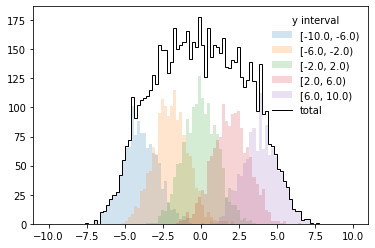

In [3]:
ax_x = bh.axis.Regular(100, -10, 10)
ax_y = bh.axis.Regular(5, -10, 10)
h = bh.Histogram(ax_x, ax_y)
h.fill(x, y)
for i, (a, b) in enumerate(ax_y):
    plt.stairs(h.values()[:,i], ax_x.edges, label=f"[{a}, {b})",
               fill=True, alpha=0.2)
h1 = h[:, sum]
plt.stairs(h1.values(), ax_x.edges, color="k", label="total")
plt.legend(title="y interval", frameon=False);

## Fit with conditional variable

The random distribution of $x$ depends on the value of $y$. We can exploit that information in the likelihood function to obtain a more accurate estimate of the parameters.

In [4]:
def model(xy, a, b, sigma):
    x, y = xy
    mu = a + b * y
    return norm.pdf(x, mu, sigma)

nll = UnbinnedNLL((x, y), model)

m = Minuit(nll, 0.0, 0.0, 2.0)
m.limits["sigma"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.93e+04                   │              Nfcn = 130              │
│ EDM = 2.25e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │  -0.010   │   0.012   │            │            │         │         │       │
│ 1 │ b     │  0.4993   │  0.0022   │            │            │         │         │       │
│ 2 │ sigma │   0.986   │   0.008   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │        a        b    sigma │
├───────┼────────────────────────────┤
│     a │ 0.000142 1.31e-08 5.73e-08 │
│     b │ 1.31e-08 4.76e-06 1.02e-08 │
│ sigma │ 5.73e-08 1.02e-08 7.08e-05 │
└───────┴────────────────────────────┘

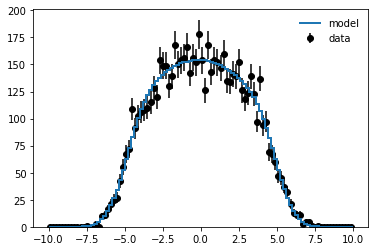

In [5]:
# construct model representation for comparison with data histogram
a, b, sigma = m.values

# get expected content per bin from cdf, sum over the individual cdfs
v = np.diff(np.sum(norm.cdf(ax_x.edges[:,np.newaxis],
                            mu(y, a, b), sigma), axis=1))

plt.stairs(v, ax_x.edges, label="model", zorder=5, lw=2)
plt.errorbar(ax_x.centers, h1.values(), h1.variances() ** 0.5,
             fmt="ok", label="data")
plt.legend(frameon=False);

## Fit without conditional variable

We can also ignore the dependence of $x$ and $y$ and just fit the total $x$ distribution with a model built from the distribution of $y$ values. This also works in this case, but information is lost and therefore the parameter uncertainties become larger than the previous case.

On top of that, the calculation in this case is much slower, because calculating the pdf is more expensive. We parallelise the computation with numba.

In [6]:
nb.config.THREADING_LAYER = 'workqueue'


@nb.njit(parallel=True)
def model(x, a, b, sigma):
    mu = a + b * y
    total = np.zeros_like(x)
    for i in nb.prange(len(mu)):
        total += norm.pdf(x, mu[i], sigma)
    return total


nll = UnbinnedNLL(x, model)
m2 = Minuit(nll, *m.values)
m2.limits["sigma"] = (0, None)
m2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -8.774e+04                 │              Nfcn = 64               │
│ EDM = 1.12e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │   0.002   │   0.029   │            │            │         │         │       │
│ 1 │ b     │   0.500   │   0.005   │            │            │         │         │       │
│ 2 │ sigma │   0.98    │   0.04    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         a         b     sigma │
├───────┼───────────────────────────────┤
│     a │   0.00084  4.35e-06 -3.16e-05 │
│     b │  4.35e-06  2.43e-05 -0.000141 │
│ sigma │ -3.16e-05 -0.000141    0.0016 │
└───────┴───────────────────────────────┘

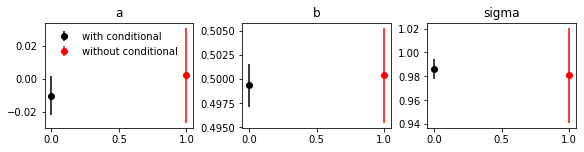

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2), constrained_layout=True)
for par, axi in zip(m.parameters, ax):
    axi.set_title(par)
    axi.errorbar(0, m.values[par], m.errors[par],
                 fmt="ok", label="with conditional")
    axi.errorbar(1, m2.values[par], m2.errors[par],
                 fmt="or", label="without conditional")
ax[0].legend(frameon=False, loc="upper left");